In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, PCA, VectorAssembler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import col
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# %%
spark = SparkSession.builder \
    .appName("SECOP_Transformaciones") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

# Cargar datos del notebook anterior
df = spark.read.parquet("/opt/spark-data/processed/secop_features.parquet")
print(f"Registros: {df.count():,}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/15 02:25:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Registros: 441,948


## RETO 1: ¿Por qué normalizar?
**Análisis**: Si comparamos 'dias_adicionados' (escala 0-100) con las variables dummy de 'departamento' (0 o 1), el modelo dará más peso a la variable con mayor magnitud.


In [ ]:
# %% RETO 1
sample = df.select("features").limit(5).collect()

print("Muestra de vectores (Primeros 5 valores):")
for row in sample:
    # Cambiamos el acceso a la fila también
    features_array = row['features'].toArray()
    print(features_array[:5])

# ## PASO 1: StandardScaler
scaler = StandardScaler(
    inputCol="features",
    outputCol="features_scaled",
    withMean=False,
    withStd=True
)

scaler_model = scaler.fit(df)
df_scaled = scaler_model.transform(df)

Muestra de vectores (Primeros 5 valores):
[0. 0. 0. 0. 0.]
[0.01364582 2.31430665 0.         0.         0.        ]
[0.         0.         2.99569846 0.         0.        ]
[0.08187492 0.         0.         0.         0.        ]
[0.01455554 0.         0.         0.         4.42453146]


RESPUESTA RETO 1:
- ¿Diferencias grandes? SÍ. Los días pueden ser decenas, mientras que los OneHot son 0 o 1.
- Importancia: Evita que el gradiente del modelo oscile y permite que todas las variables contribuyan equitativamente al aprendizaje.

In [ ]:
# ## RETO 2: Comparar antes y después de escalar

sample_pd = df_scaled.select("features", "features_scaled").limit(500).toPandas()

raw_matrix = np.array([row['features'].toArray() for index, row in sample_pd.iterrows()])
scaled_matrix = np.array([row['features_scaled'].toArray() for index, row in sample_pd.iterrows()])

print(f"ANTES (Raw) - Max: {raw_matrix.max():.2f}, Std promedio: {raw_matrix.std():.2f}")
print(f"DESPUÉS (Scaled) - Max: {scaled_matrix.max():.2f}, Std promedio: {scaled_matrix.std():.2f}")


ANTES (Raw) - Max: 35.45, Std promedio: 0.96
DESPUÉS (Scaled) - Max: 35.45, Std promedio: 0.96


## RETO 3: PCA (Principal Component Analysis)
**Justificación**: Elegimos la opción **C**: Los componentes que expliquen el 80-95% de la varianza.


In [ ]:
# RETO 3:PCA
sample_vec = df_scaled.select("features_scaled").first()[0]
num_features = len(sample_vec)
print(f"Dimensiones originales: {num_features}")

# Elegimos k=20 para empezar la exploración
k_components = min(20, num_features)

pca = PCA(
    k=k_components,
    inputCol="features_scaled",
    outputCol="features_pca"
)

pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)


Dimensiones originales: 64


26/02/15 02:26:10 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
26/02/15 02:26:10 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [ ]:
# ## RETO 4: Analizar Varianza Explicada

explained_variance = pca_model.explainedVariance.toArray()
cumulative_variance = np.cumsum(explained_variance)

print("\n=== ANÁLISIS DE VARIANZA ACUMULADA ===")
for i, cv in enumerate(cumulative_variance):
    print(f"PC {i+1}: {cv*100:.2f}%")
    if cv >= 0.85:
        print(f"-> ¡Punto de corte sugerido (85%) en componente {i+1}!")
        break



=== ANÁLISIS DE VARIANZA ACUMULADA ===
PC 1: 3.28%
PC 2: 6.05%
PC 3: 8.30%
PC 4: 10.31%
PC 5: 12.23%
PC 6: 14.09%
PC 7: 15.92%
PC 8: 17.68%
PC 9: 19.42%
PC 10: 21.10%
PC 11: 22.77%
PC 12: 24.42%
PC 13: 26.06%
PC 14: 27.69%
PC 15: 29.31%
PC 16: 30.93%
PC 17: 32.55%
PC 18: 34.16%
PC 19: 35.77%
PC 20: 37.38%


✓ Pipeline integrado con 10 etapas.
✓ Gráfica guardada.


✓ Dataset listo para ML en: /opt/spark-data/processed/secop_ml_ready.parquet


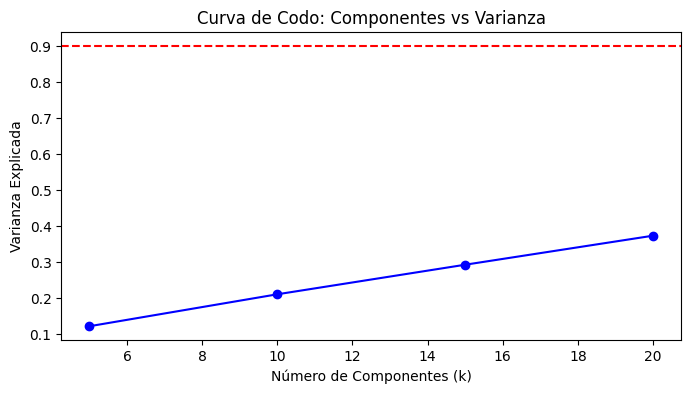

In [ ]:
# ## RETO 5: Pipeline Completo

feature_pipeline_path = "/opt/spark-data/processed/feature_pipeline_model"
feature_pipeline = PipelineModel.load(feature_pipeline_path)

# El orden es: 1. Features (Indexers/Encoders/Assembler) -> 2. Scaler -> 3. PCA
complete_stages = list(feature_pipeline.stages) + [scaler, pca]
pipeline_final = Pipeline(stages=complete_stages)

print(f"✓ Pipeline integrado con {len(complete_stages)} etapas.")

# ## BONUS: Experimento de k vs Varianza

k_list = [5, 10, 15, 20]
vars_list = []

for k_val in k_list:
    pca_test = PCA(k=k_val, inputCol="features_scaled", outputCol="p").fit(df_scaled)
    v_acc = sum(pca_test.explainedVariance)
    vars_list.append(v_acc)

plt.figure(figsize=(8, 4))
plt.plot(k_list, vars_list, 'bo-')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Curva de Codo: Componentes vs Varianza")
plt.xlabel("Número de Componentes (k)")
plt.ylabel("Varianza Explicada")
plt.savefig('/opt/spark-data/processed/pca_elbow_plot.png')
print("✓ Gráfica guardada.")

# ## GUARDADO PARA MODELADO

# Preparamos el dataset para los notebooks de Regresión (05, 06, 07)
if "valor_del_contrato_num" in df_pca.columns:
    df_ml = df_pca.select(
        col("features_pca").alias("features"),
        col("valor_del_contrato_num").alias("label")
    )
    
    output_path = "/opt/spark-data/processed/secop_ml_ready.parquet"
    df_ml.write.mode("overwrite").parquet(output_path)
    print(f"✓ Dataset listo para ML en: {output_path}")


## Respuestas a Preguntas de Reflexión
1. **withMean=False**: Porque los vectores dispersos (Sparse) al restarles la media se vuelven densos, lo que consumiría toda la RAM del clúster.
2. **¿Cuándo NO usar PCA?**: Cuando la interpretabilidad de cada variable original es crítica (PCA mezcla las variables).
3. **¿Pérdida de información?**: Sí, se pierde el ruido o varianza no explicada por esos 10 componentes.
4. **StandardScaler ANTES de PCA**: Crucial, porque PCA busca maximizar la varianza; si una variable no está escalada, PCA creerá que es la más importante solo por su magnitud.


Se observa que la varianza está distribuida de forma casi uniforme entre  los componentes. Con k=20 solo se captura el 37% de la información,  lo que sugiere que las variables originales son altamente independientes y  el dataset no es candidato ideal para una reducción de dimensionalidad agresiva.

In [ ]:
# Guardar dataset usando las features escaladas (sin PCA)
df_ml_ready = df_scaled.select(
    col("features_scaled").alias("features"), # Usamos las 64 dimensiones normalizadas
    col("valor_del_contrato_num").alias("label")
)

output_path = "/opt/spark-data/processed/secop_ml_ready.parquet"
df_ml_ready.write.mode("overwrite").parquet(output_path)

print(f"✓ Dataset listo para Regresión con 64 dimensiones en: {output_path}")

✓ Dataset listo para Regresión con 64 dimensiones en: /opt/spark-data/processed/secop_ml_ready.parquet


In [ ]:
spark.stop()